In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize'] = (20,10)
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

In [2]:
cases = pd.read_csv('WHO-COVID-19-global-data-2.csv')
cases = cases[['Date_reported','Country','New_cases','Cumulative_cases', 'New_deaths', 'Cumulative_deaths']]
country_name = "Germany"
country_filter = cases['Country'] == country_name
cases = cases[country_filter]

In [3]:
date = cases['Date_reported'].values
deats_by_day = cases['New_deaths'].values
cases_by_day = cases['New_cases'].values

In [4]:
number_of_items = len(date)
days = np.arange(1, number_of_items+1)

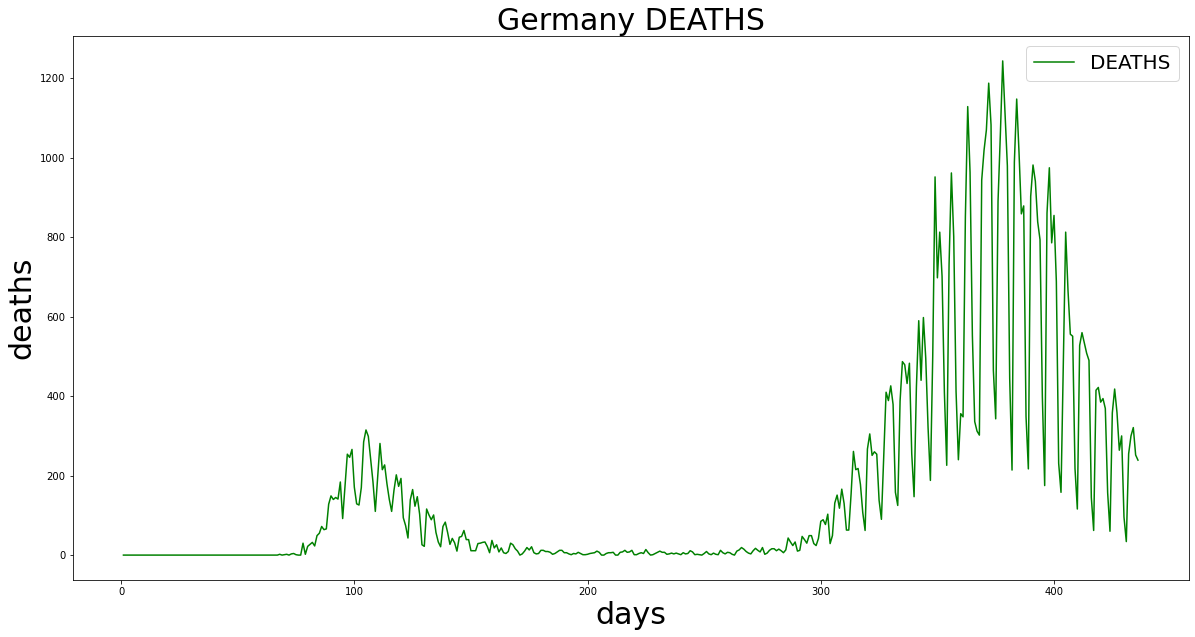

In [5]:
plt.plot(days, deats_by_day, label="DEATHS", color="green")
plt.title(country_name+" DEATHS", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("deaths", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [6]:
def mape(true, pred):
    return np.mean(np.abs((true-pred)/true))*100
def mse(true, predictions):
    return np.mean((true-predictions)**2)
def rmse(true, predictions):
    return np.mean((true-predictions)**2)**0.5

In [7]:
deaths_starting_from_67 = deats_by_day[67:]

# EXPONENTIAL SMOOTHING

# Simple Exp Smoothing

In [8]:
alpha_grid = np.arange(0.01, 1, 0.01)

In [9]:
def apply_simple_exp(data, alpha):
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha,optimized=False)
    return model.fittedvalues

In [10]:
mask = deaths_starting_from_67 !=0
pred_lst = []
error_list = []
alpha_lst = []
for alpha in alpha_grid:
    predictions = np.array(apply_simple_exp(deaths_starting_from_67, alpha))
    pred_lst.append(predictions)
    error_list.append(mape(deaths_starting_from_67[mask], predictions[mask]))
    alpha_lst.append(alpha)

/Users/furkanyakal/opt/anaconda3/envs/libs/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [11]:
min_index = np.argmin(error_list)
print("Best alpha is: {}".format(alpha_lst[min_index]))

Best alpha is: 0.99


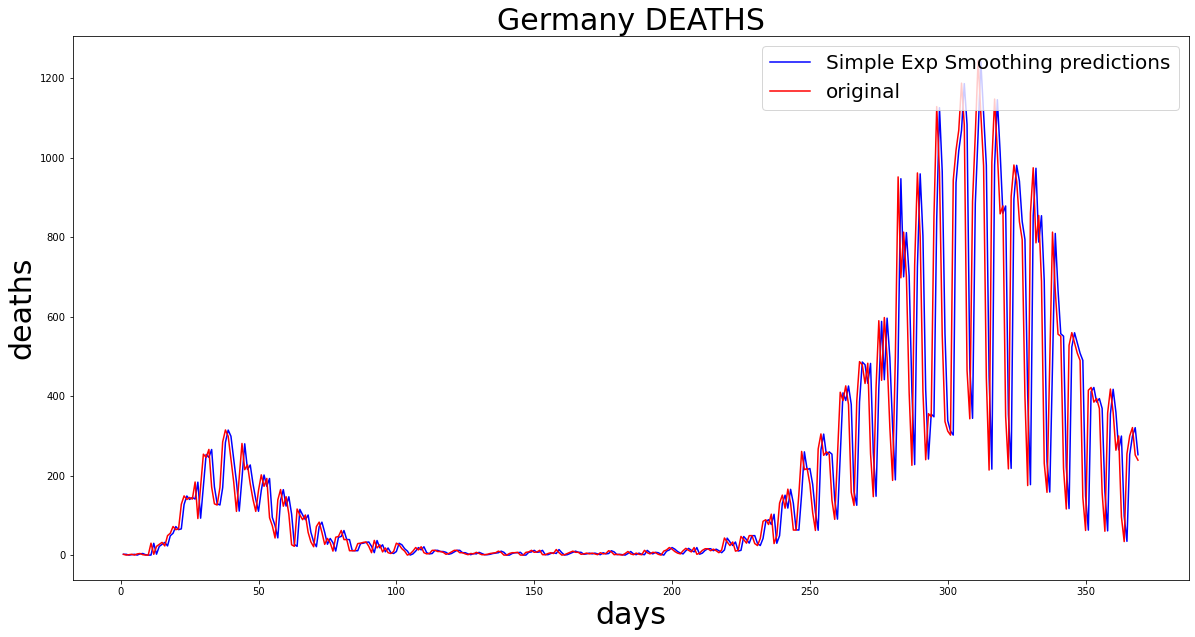

In [12]:
plt.plot(np.arange(1,len(pred_lst[min_index])+1), pred_lst[min_index], label="Simple Exp Smoothing predictions", color="blue")
plt.plot(np.arange(1,len(deaths_starting_from_67)+1), deaths_starting_from_67, label="original", color="red")
plt.title(country_name+" DEATHS", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("deaths", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [13]:
mape_ = error_list[min_index]
mape_

66.1775231729747

In [14]:
mse(deaths_starting_from_67[mask], pred_lst[min_index][mask])

20851.507895515446

In [15]:
rmse(deaths_starting_from_67[mask], pred_lst[min_index][mask])

144.40051210267728

# Triple Exp Smoothing

In [16]:
model = ExponentialSmoothing(deaths_starting_from_67,seasonal_periods=7, trend='add',seasonal = 'add').fit()
fitted_values = model.fittedvalues

/Users/furkanyakal/opt/anaconda3/envs/libs/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


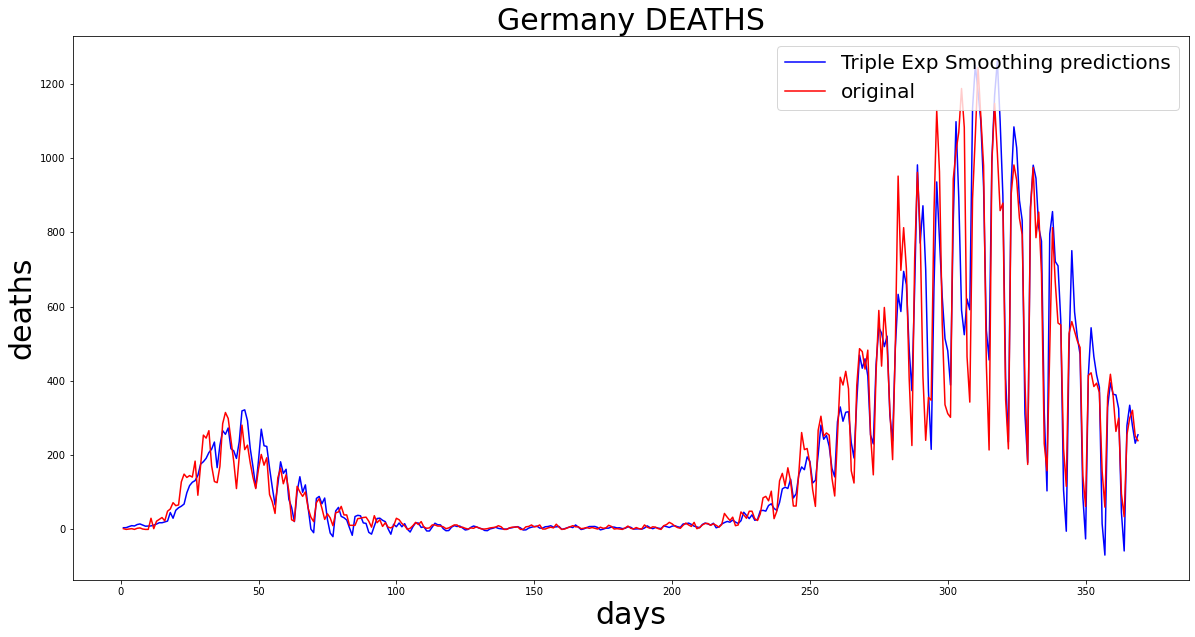

In [17]:
plt.plot(np.arange(1,len(fitted_values)+1), fitted_values, label="Triple Exp Smoothing predictions", color="blue")
plt.plot(np.arange(1,len(deaths_starting_from_67)+1), deaths_starting_from_67, label="original", color="red")
plt.title(country_name+" DEATHS", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("deaths", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [18]:
fitted_values = np.array(fitted_values)

In [19]:
mape(deaths_starting_from_67[mask], fitted_values[mask])

60.38389686465974

In [20]:
mse(deaths_starting_from_67[mask], fitted_values[mask])

7048.383796701731

In [21]:
rmse(deaths_starting_from_67[mask], fitted_values[mask])

83.95465321649378

# ARIMA

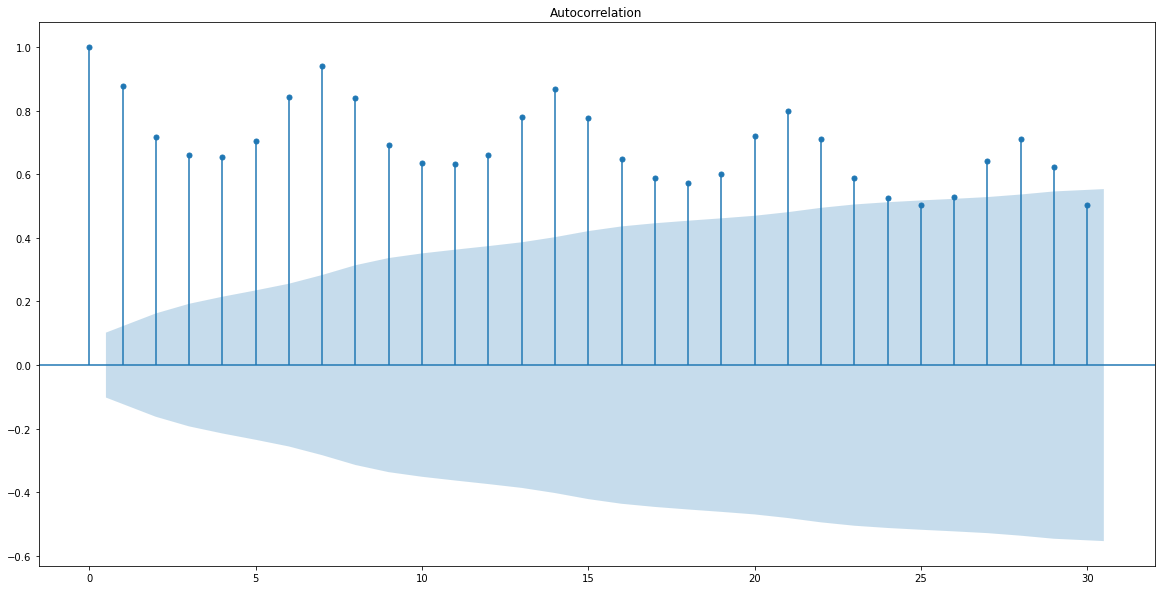

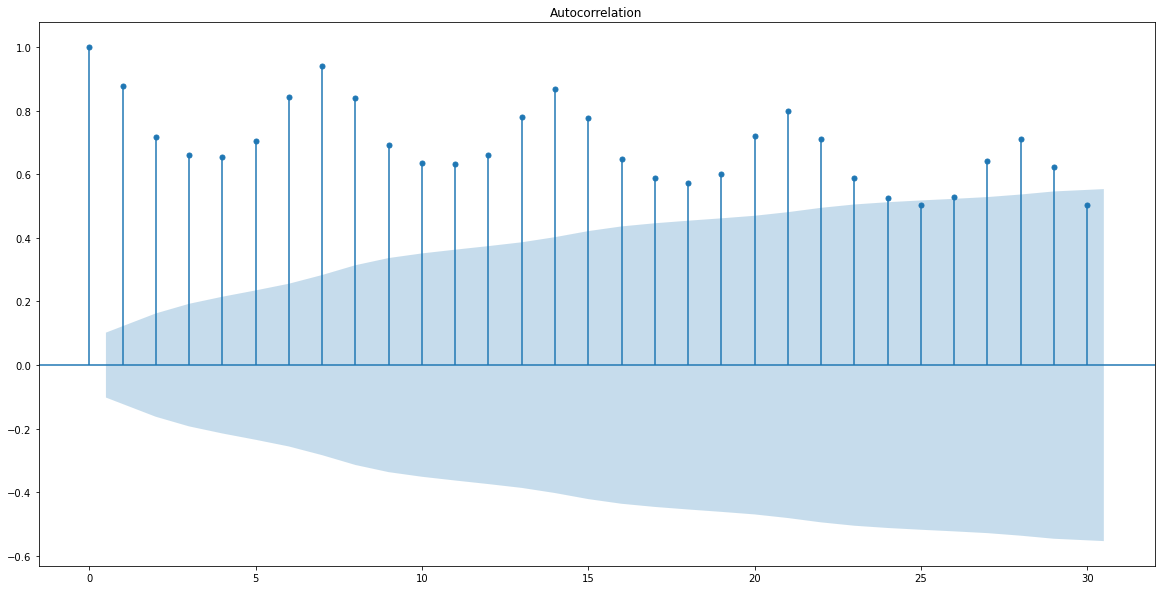

In [22]:
plot_acf(deaths_starting_from_67, lags=30)

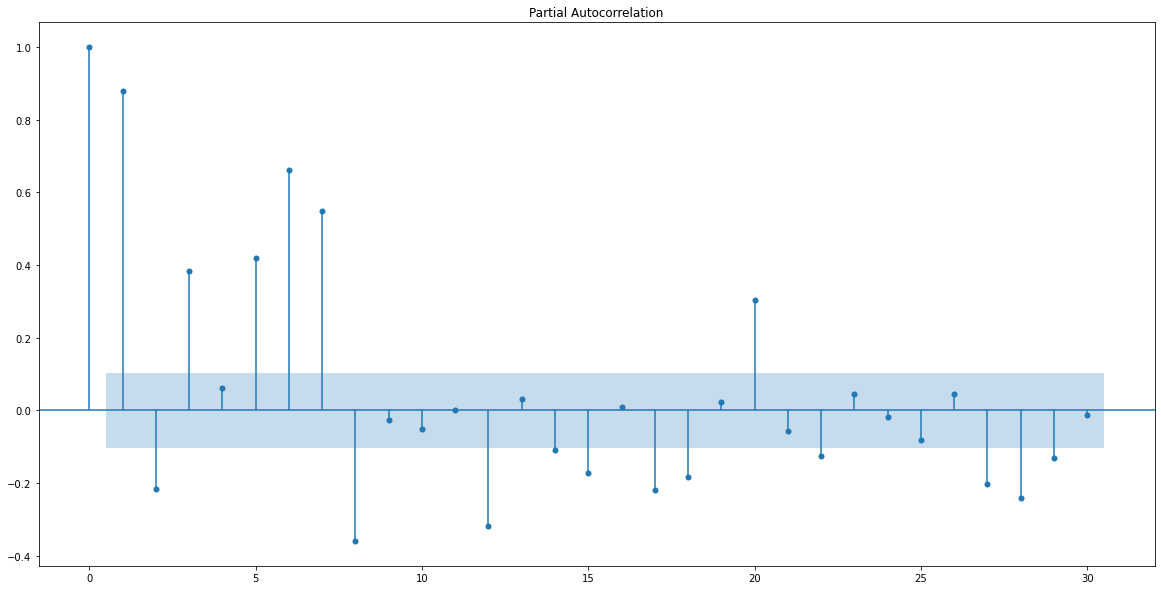

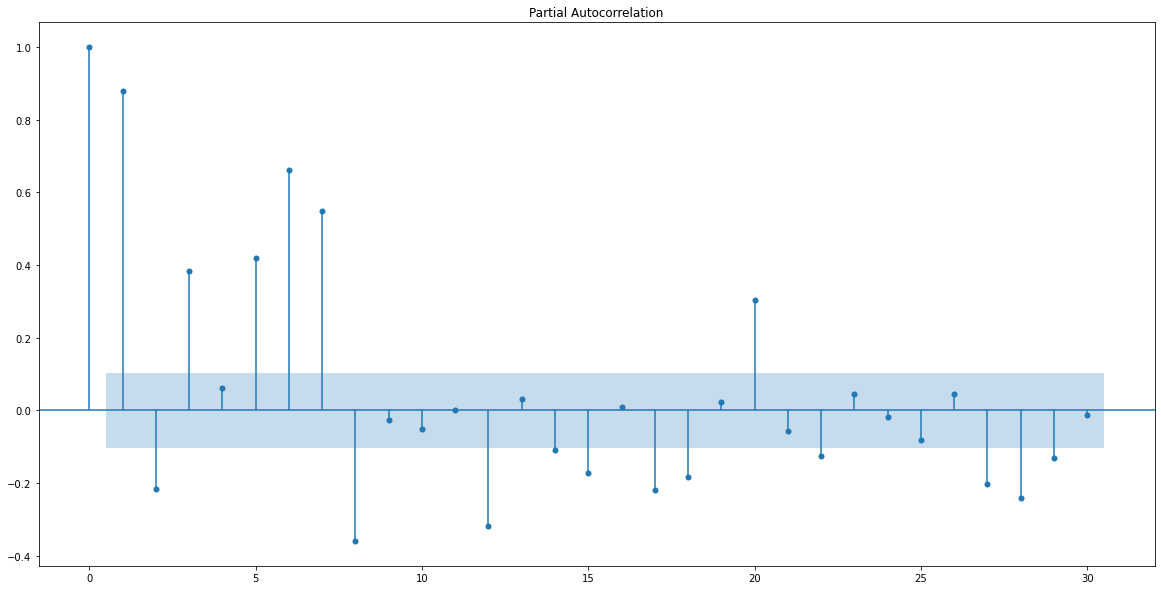

In [23]:
plot_pacf(deaths_starting_from_67, lags=30)

# LAG7

In [24]:
lag_7_deaths = deaths_starting_from_67[:len(deaths_starting_from_67)-7] - deaths_starting_from_67[7:]

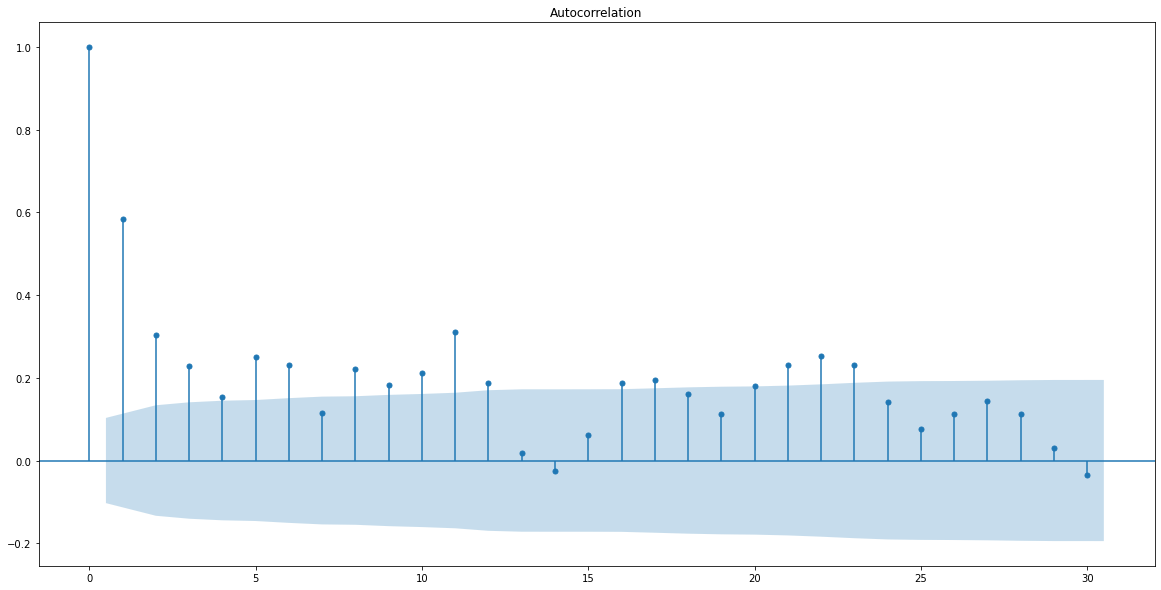

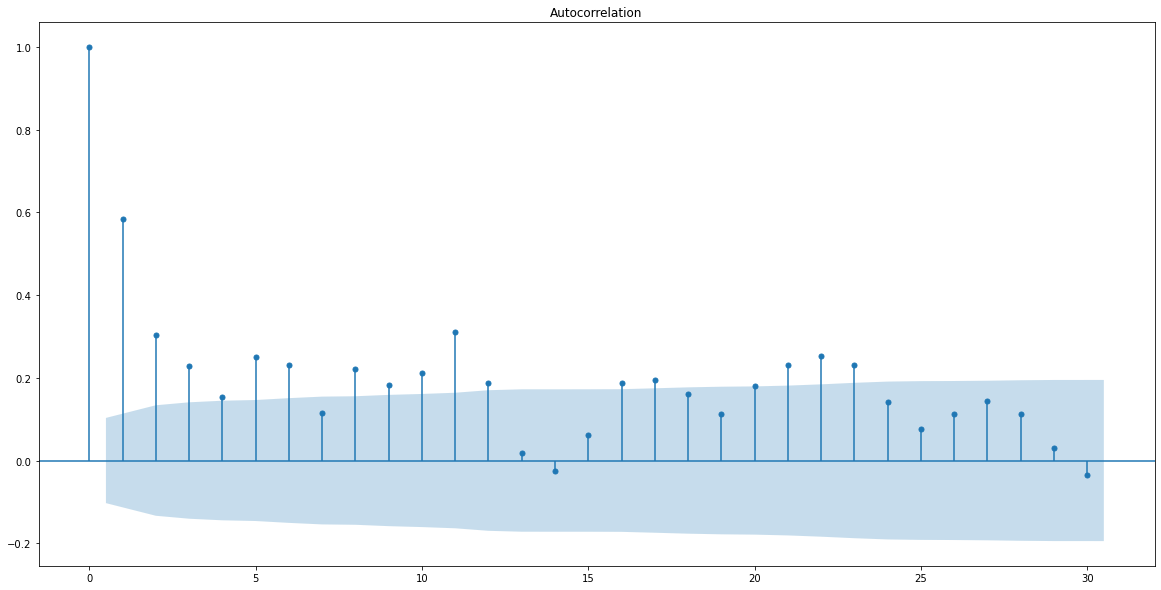

In [25]:
plot_acf(lag_7_deaths, lags=30)

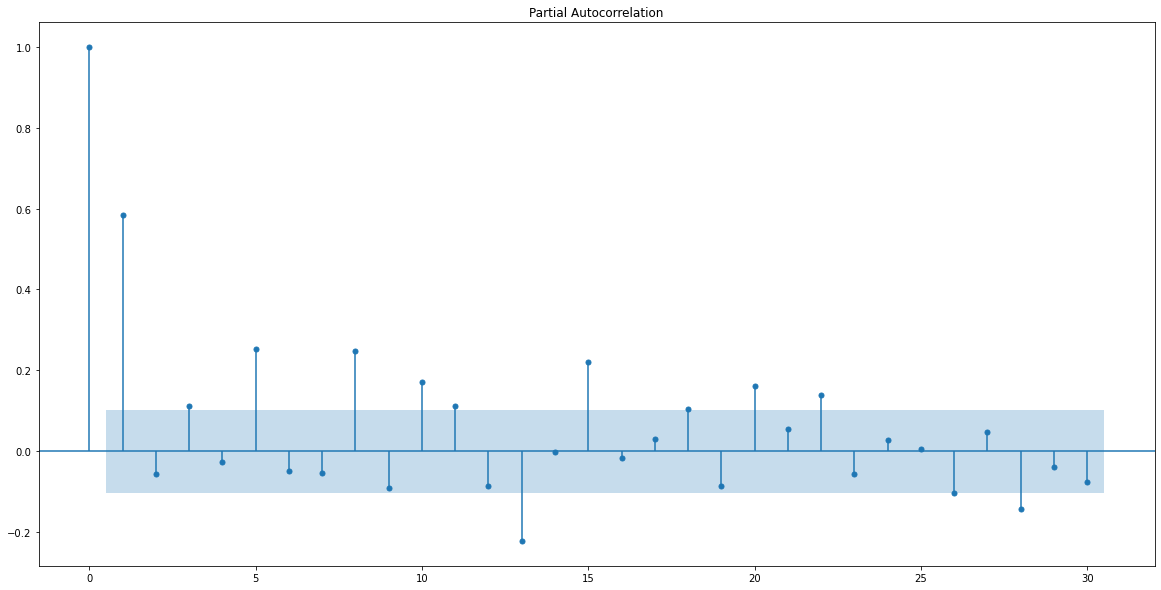

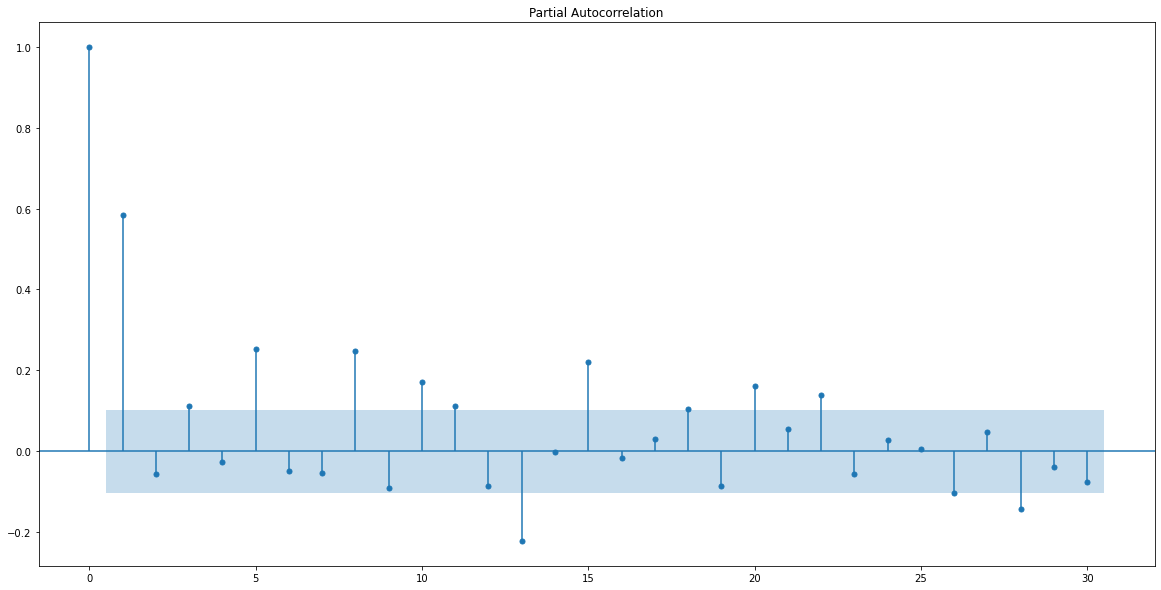

In [26]:
plot_pacf(lag_7_deaths, lags=30)

# ARIMA([1,5], 0, 0)

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(lag_7_deaths, order=([1,5],0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                  362
Model:             ARIMA([1, 5], 0, 0)   Log Likelihood               -2077.522
Date:                 Mon, 29 Mar 2021   AIC                           4163.045
Time:                         16:55:48   BIC                           4178.611
Sample:                              0   HQIC                          4169.233
                                 - 362                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0586     15.343     -0.265      0.791     -34.130      26.013
ar.L1          0.5574      0.016     33.869      0.000       0.525       0.590
ar.L5          0.1660      0.029      5.746      0.000       0.109       0.223
sigma2      5643.6974    135.629     41.611      0.000    5377.869    5909.525
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):              4986.63
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):              19.34   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
predictions = model_fit.predict(1, len(lag_7_deaths))

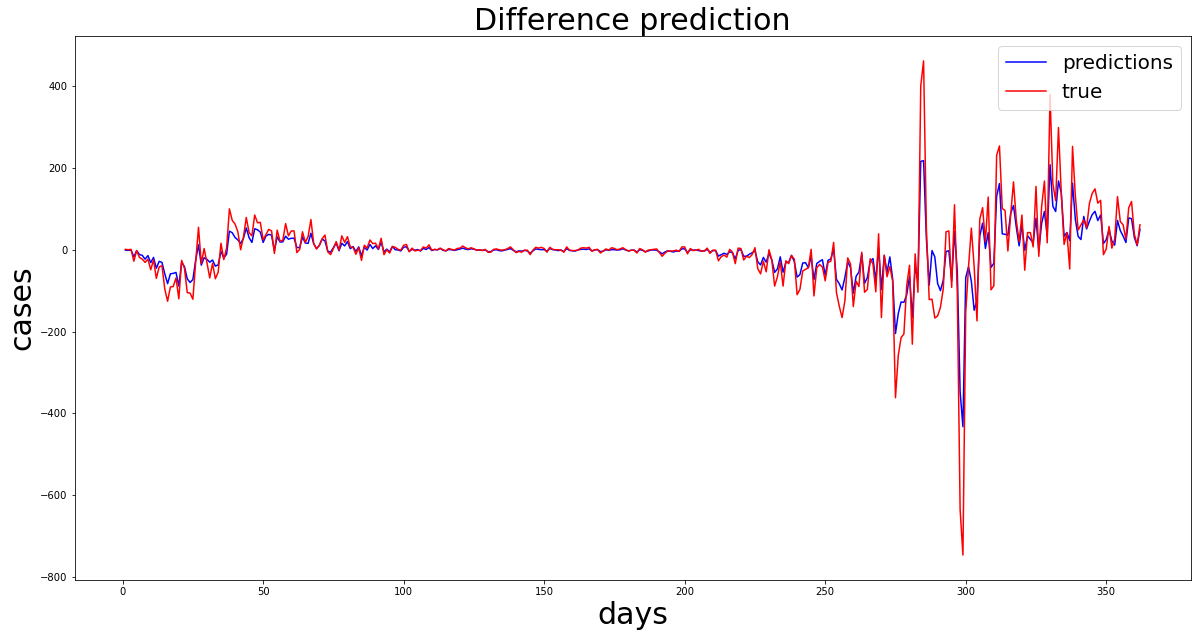

In [29]:
plt.plot(np.arange(1,len(predictions)+1), predictions, label="predictions", color="blue")
plt.plot(np.arange(1,len(lag_7_deaths)+1), lag_7_deaths, label="true", color="red")
plt.title("Difference prediction", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("cases", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [30]:
true = deaths_starting_from_67[:len(deaths_starting_from_67)-7]
predictions = predictions + deaths_starting_from_67[7:]

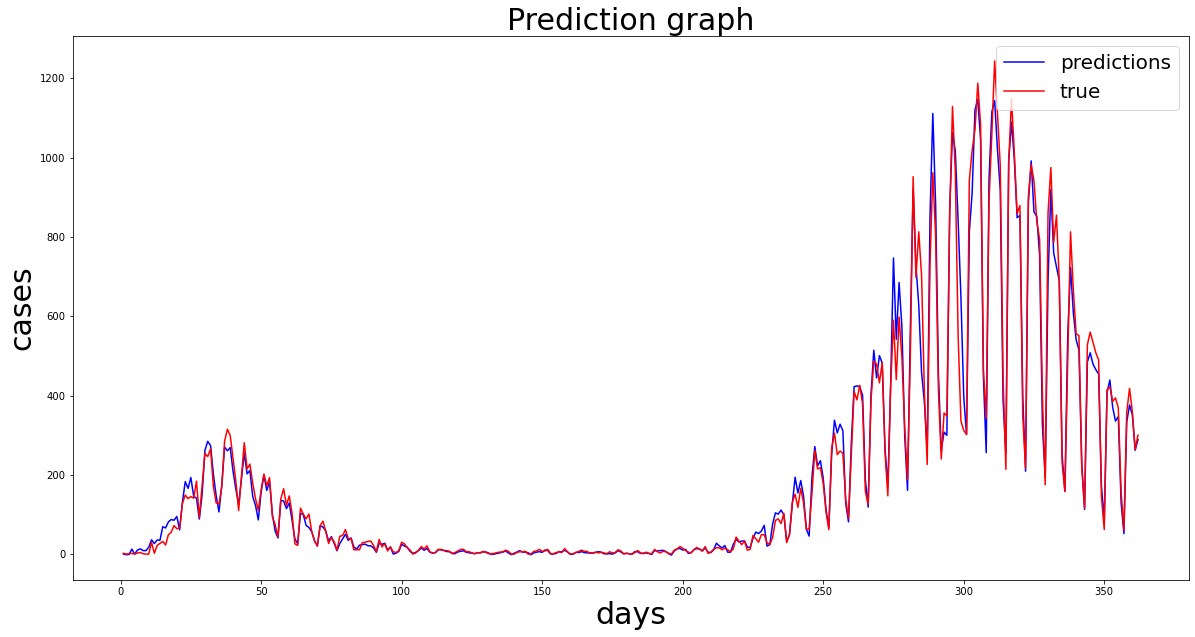

In [31]:
plt.plot(np.arange(1,len(predictions)+1), predictions, label="predictions", color="blue")
plt.plot(np.arange(1,len(true)+1), true, label="true", color="red")
plt.title("Prediction graph", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("cases", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [32]:
true_mask = true!=0

In [33]:
mape(true[true_mask], predictions[true_mask])

33.83236273684683

In [34]:
mse(true[true_mask], predictions[true_mask])

1856.1735200497283

In [35]:
rmse(true[true_mask], predictions[true_mask])

43.083332276528104

# ARIMA([1,5], 1, 0)

In [36]:
model = ARIMA(lag_7_deaths, order=([1,5],1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                  362
Model:             ARIMA([1, 5], 1, 0)   Log Likelihood               -2114.430
Date:                 Mon, 29 Mar 2021   AIC                           4234.860
Time:                         16:55:49   BIC                           4246.526
Sample:                              0   HQIC                          4239.498
                                 - 362                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1383      0.028     -5.003      0.000      -0.192      -0.084
ar.L5          0.1142      0.031      3.634      0.000       0.053       0.176
sigma2      7159.3492    176.611     40.537      0.000    6813.199    7505.499
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):              4188.84
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):              21.25   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
predictions = model_fit.predict(1, len(lag_7_deaths))

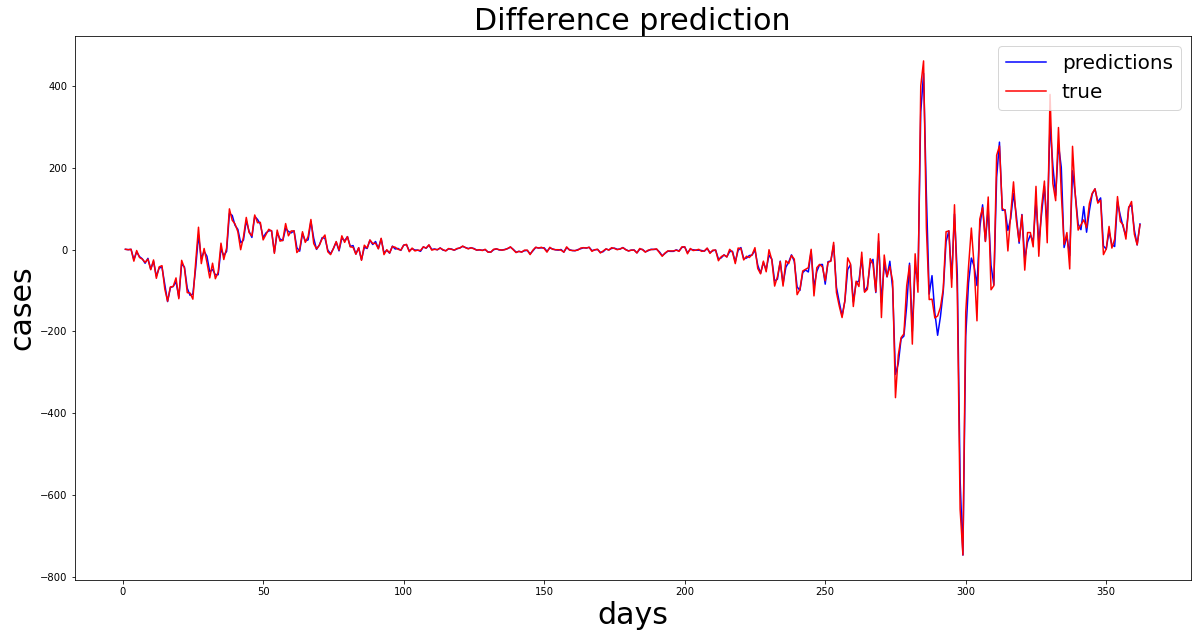

In [38]:
plt.plot(np.arange(1,len(predictions)+1), predictions, label="predictions", color="blue")
plt.plot(np.arange(1,len(lag_7_deaths)+1), lag_7_deaths, label="true", color="red")
plt.title("Difference prediction", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("cases", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [39]:
true = deaths_starting_from_67[:len(deaths_starting_from_67)-7]
predictions = predictions + deaths_starting_from_67[7:]

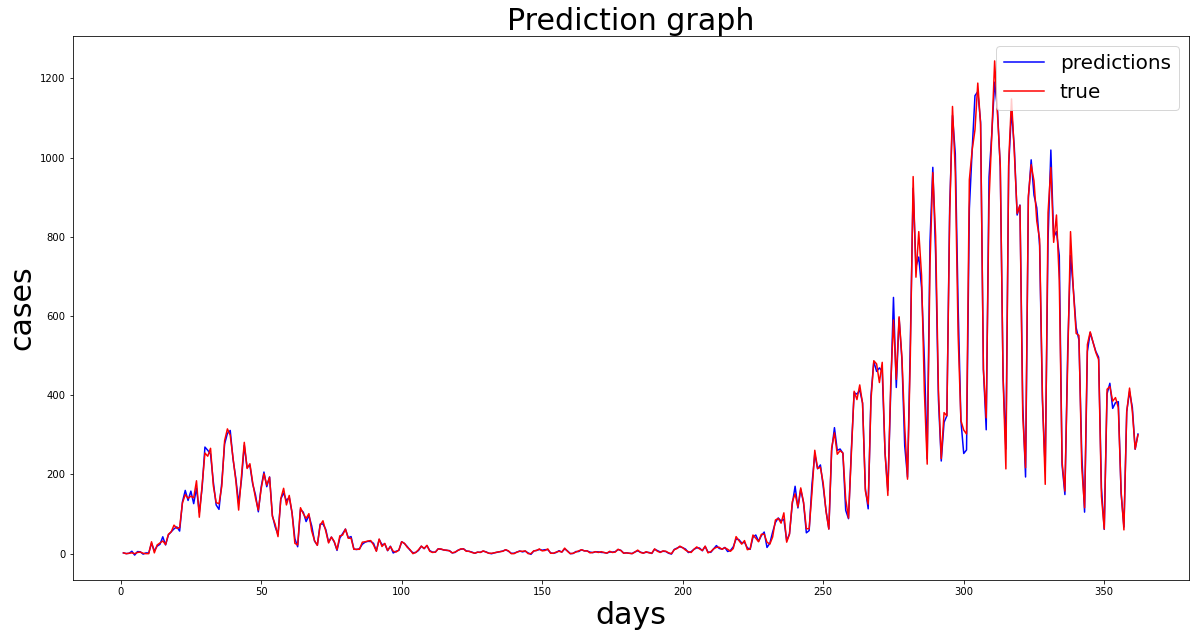

In [40]:
plt.plot(np.arange(1,len(predictions)+1), predictions, label="predictions", color="blue")
plt.plot(np.arange(1,len(true)+1), true, label="true", color="red")
plt.title("Prediction graph", fontsize = 30)
plt.xlabel("days", fontsize = 30)
plt.ylabel("cases", fontsize = 30)
plt.legend(loc=1, prop={'size':20})

In [41]:
true_mask = true!=0

In [42]:
mape(true[true_mask], predictions[true_mask])

13.670948412441142

In [43]:
mse(true, predictions)

287.5726867822375

In [44]:
rmse(true, predictions)

16.957968238625686